In [2]:
import tensorflow as tf
#tf.enable_eager_execution()#这东西还必须在最开始就执行，放后面都不行


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow_hub as hub
from tensorflow.keras import layers



In [4]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 
#@param {type:"string"}
#在这里，我们直接down下来mobilenet_v2（一个已经训练好的模型）


# 建立model

In [5]:
IMAGE_SHAPE = (224, 224)

#将下载下来的模型作为keras的一个layer，封装在classifier之中。
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))#tuple的链接(tuple1)+(tuple2)
])
#该图层包装可调用对象以用作Keras图层。可调用对象可以直接传递，
#也可以由带有传递给的句柄的Python字符串指定hub.load()。



这里我们把hub封装为一个keras的layer中，可以和其他layer组合。  
在这里我们建立的model叫做classifier，即这个model只有一层，就是hub层

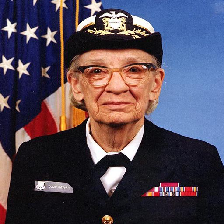

In [6]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
#single image
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper



In [7]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [8]:
result = classifier.predict(grace_hopper[np.newaxis, ...])#model.predict(input)
result.shape
#因为是单个图片，而网络是要处理大量图片的，单个图片对于大量图片的维度而言，少了一个维度。
#mat[np.newaxis,...]增加一个维度,在这里增加的是第一维度。

(1, 1001)

result的结果是1001个逻辑结果组成的vector

In [9]:
predicted_class = np.argmax(result[0], axis=-1)
        #axis=0,按列，axis=1，按行，向下是第一维度，向右是第二维度
        #如果axis = 0，则它将是第一个维度，如果axis = -1，则它将是最后一个维度。
        #axis=num，其中num指的是第几维度，-num表示倒数。
predicted_class


653

## Decode（解码）

In [10]:
##把预测的结果，转变成实际意义的label名称
#download the label
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())



In [11]:
type(imagenet_labels)

numpy.ndarray

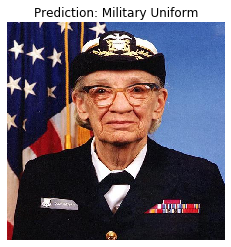

In [12]:
plt.imshow(grace_hopper)
    #imshow就可以把matrix变成图片
plt.axis('off')
    
predicted_class_name = imagenet_labels[predicted_class]
    #label是以np.ndarray的格式存放的
_ = plt.title("Prediction: " + predicted_class_name.title())

# transfer learning

In [13]:
data_root = tf.keras.utils.get_file(
  'flower_photos',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)


In [44]:
data_root


'/Users/allen/.keras/datasets/flower_photos'

### 批量处理图片  (preprocessing.image.ImageDataGenerator)

In [14]:
## normalize+变换一下图片的size。
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
        ##批量处理image的方法（旋转，裁剪，翻转等的图片批量处理的方法）
        #rescale（num）像素标准化！所有像素矩阵直接*num后
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)
#flow_from_directory, 指的明输入的位置，以str的形式

#通过实时数据增强生成张量图像数据批次。数据将不断循环（按批次）
#flow方法用于对已经读入内存的图片数据执行处理，flow_from_directory对文件夹下的数据执行预处理，
#flow适用于小数据集、flow_from_directory适用于大的数据集。
#这两个处理方法都无限循环生成预处理后的batch数据，
#实际在类定义和方法调用时只是定义预处理的功能，在网络训练时才会真正生成batch数据，并且用一个生成一个。


Found 3670 images belonging to 5 classes.


In [15]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

##image_data把处理的一个batch数据分别拆开，并分别赋值给image_batch和label_batch

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


## Run the classifier on a batch of image

In [16]:
result_batch = classifier.predict(image_batch)
#返回的是label对应预测相对概率

In [17]:
result_batch.shape
#a batch有32个图片。

(32, 1001)

In [18]:
predicted_class_name = imagenet_labels[np.argmax(result_batch,axis=-1)]
#predict出来的是以label为index，以相对概率为value的np.array
#需要把predict的对应概率最大值的index找到，才是其预测的label。
predicted_class_name

array(['daisy', 'cardoon', 'daisy', 'daisy', 'toyshop', 'vase', 'maze',
       'picket fence', 'velvet', 'daisy', 'velvet', 'daisy',
       'shower curtain', 'brassiere', 'daisy', 'vase', 'ant', 'cardoon',
       'greenhouse', 'daisy', 'daisy', 'daisy', 'monarch', 'daisy',
       'cardoon', 'daisy', 'daisy', 'orange', 'velvet', 'daisy', 'daisy',
       'bee'], dtype='<U30')

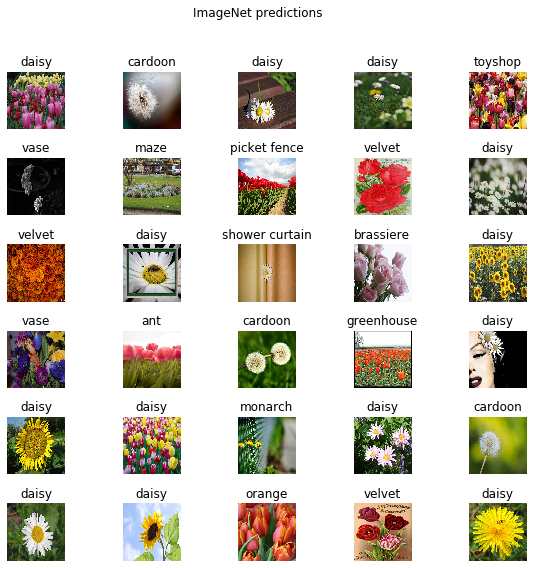

In [19]:
#画图
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_name[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

这是用完全不同的神经网络去预测毫不相关的内容。
可以看到，预测的结果很差很差。  

因此这里我们需要加个顶层神经网络，只训练顶层神经网络和已有神经网络之间的关联，完成迁移学习（本来学的是分辨猫和狗，我们加个帽子，只训练帽子，就会分辨花的种类了）

## Download headless model

In [20]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}
#这是个字符串


In [21]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

#keraslayer的obj是字符串类型的地址，可以是本地的也可以是URL（网页的）

In [22]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)
#image_batch还是一批花的image
#返回的是32个维度为1280的vector

(32, 1280)


### freezen layers ( .hub.KerasLayer.trainable=False)

In [23]:
#freeze我们不需要继续学习和修改的layer
feature_extractor_layer.trainable = False
#这里我们不需要在对我们下载下来的headless NN继续修改了

### 建立结构

In [24]:
#新建一个以URL上的且不需要在改动的中心层为核心，在堆叠一个layer
model = tf.keras.Sequential([
  feature_extractor_layer,#我们直接把这个layer放在sequential的一层layer里面
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
#观察一下prediction给出的结果
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

### compile

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [27]:
#自己写一个log版本的loss and acc
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):#先定义几个属性
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])#把loss one by one的放进来
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [28]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit(image_data, epochs=2,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats_callback])

Epoch 1/2


W0821 20:35:59.298944 4692440512 deprecation.py:323] From /Users/allen/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


115/115 [==============================] - 122s 1s/step - loss: 0.6669 - acc: 0.8438
Epoch 2/2
115/115 [==============================] - 123s 1s/step - loss: 0.3348 - acc: 0.8750


In [29]:
type(batch_stats_callback)

__main__.CollectBatchStats

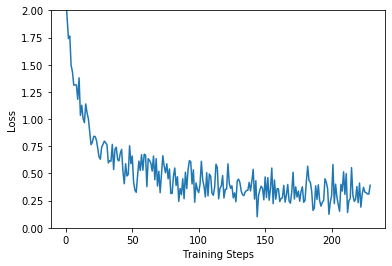

In [30]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

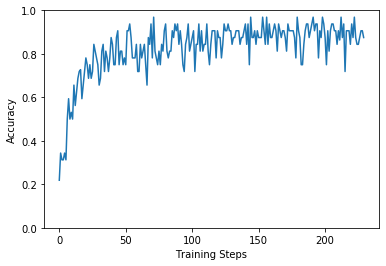

In [31]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

## prediction

In [32]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

#tips：
#for的用法：
#[a + b for a in x for b in y if a%2 == 0 and b%2 ==0],一定用方括号廓起来
#这里两个for之间是嵌套的关系
#把x中的一个一个拿出来，赋值给a，同理从y中拿出来的元素，赋值给b，
#判定如果a和b都能被2整除，则执行a+b的操作


array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [33]:
a=[1,2,3,4]
b=[5,6,7,8]
[x+y for x in a for y in b ]

[6, 7, 8, 9, 7, 8, 9, 10, 8, 9, 10, 11, 9, 10, 11, 12]

In [34]:
#decode
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [35]:
label_id = np.argmax(label_batch, axis=-1)

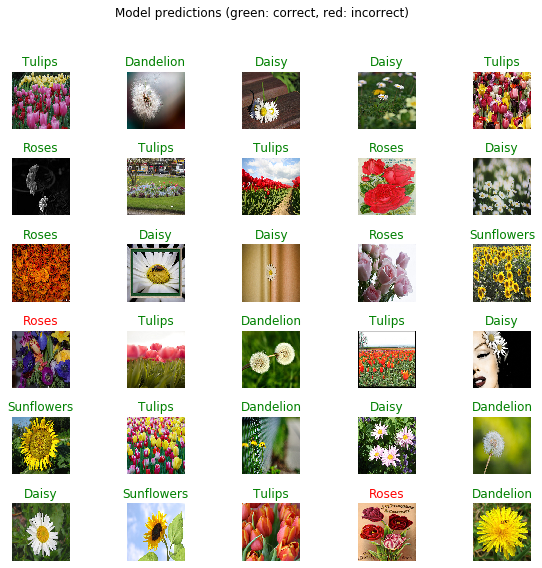

In [36]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## export model

In [43]:
import time
import os
t = time.time()
path = os.path.abspath('')
export_path = path+'/model'
tf.keras.experimental.export_saved_model(model, export_path)

export_path
#path+'/model'

W0821 20:51:26.575176 4692440512 deprecation.py:323] From /Users/allen/anaconda3/lib/python3.7/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0821 20:51:26.577110 4692440512 export_utils.py:182] Export includes no default signature!
W0821 20:51:28.155760 4692440512 meta_graph.py:450] Issue encountered when serializing variables.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
W0821 20:51:36.259418 4692440512 export_utils.py:182] Export includes no default signature!
W0821 20:51:36.998683 4692440512 meta_graph.py:

'/Users/allen/Desktop/tensorflow/model'

In [70]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path,
                                                       custom_objects={'KerasLayer':hub.KerasLayer})

#tf.keras.experimental.load_from_saved_model()加载model



In [71]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

#加载后的model就和之间一样用啦！！！

In [72]:
abs(reloaded_result_batch - result_batch).max()

0.0